# Analyzing High-Ranked League Of Legends Matches

Khawaja Arsalan Khalid

CMSC320

Final Tutorial

December 2022

## Introduction


League of Legends, also known as LoL, is one of the most popular MOBA's (Multiplayer Online Battle Arena) in the world. It is played by over 100 million active users every month and has a popular esports industry composed of 12 leagues. It is also reknown for its tie-ins with music videos, comic books, short stories, and an animated series, Arcane.

LoL is a free-to-play team-based strategy multiplayer game where two teams of five "champions" battle in player versus player combat, each team occupying and defending one half of the map (Blue vs Red). Each player controls one character known as a "champion", with a unique playstyle and multiple abilities. There are 162 champions in the game currently, leading to a vast number of combinations of possible games.

Games usually last between 20-35 minutes, but can go on for even longer depending on team matchups and player skill.

Currently, league of legends has an API that allows developers to obtain game information and statistics for every point in the game. However, there are premade datasets of game data that we are going to be using in this tutorial. The reason for this choice is we want to analyze games at the highest level to get rid of any underlying player skill differences. Getting data of this level from the API would take months to collect and aggregate, so we use this __[dataset](https://www.kaggle.com/datasets/gyejr95/league-of-legendslol-ranked-games-2020-ver1?select=match_winner_data_version1.csv)__ instead. 

The goal of this tutorial is to see if we can find a way to analyze champions in the game and gain some insight into how a match is won or lost. Since each champion is different, it might be difficult to see how this affects their win rate, but we might want to see how the champion roster performs overall and if some in-game information can allow us to predict a team's chance of winning.

### League Terminology

LoL is played on a map that looks like this:

![alt League Map](./map.jpg)

In this picture, we can see that there are towers located across the map with each team having 3 in each lane and 2 at the end for a total of 11 towers. As well, behind the third tower, there is a crystal which is called an inhibitor and can be destroyed after the tower in front of it is destroyed. 

During a match, champions become more powerful by collecting experience points, earning gold, and purchasing items to defeat the opposing team. The ultimate goal of League is to destroy the other team’s base, known as “Nexus”, but it’s not easy. Your enemies will do everything they can to kill you and destroy your base. Each base has a series of turrets and waves of minions that constantly spawn, as well as neutral monsters within the Jungle that can grant points or power ups. Your team needs to clear at least one lane to get to the enemy Nexus.

By the river in the middle, we see that there are two holes which can contain monsters that either team can slay for temporary or permanent power ups. In the lower half, the hole contains the dragon which provides permanent power ups. In the upper half, before 20 minutes, the hole will contain a Rift Herald which can help with destroying towers by ramming its head into them. However, after 20 minutes, it will contain a Baron which, when slain, provides a benefit to your team and your minions allowing you to destroy towers quickly.

## Importing Data

We will be using Python 3 along with a few libraries: __[pandas](https://pandas.pydata.org/docs/)__, __[numpy](https://numpy.org/doc/stable/)__, __[matplotlib](https://matplotlib.org/stable/users/index.html)__, __[scikit-learn](https://scikit-learn.org/stable/)__, __[searbon](https://seaborn.pydata.org/)__, and __[re](https://docs.python.org/3/library/re.html)__.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score, balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score
from sklearn.neighbors import KNeighborsClassifier
import re
from sklearn.linear_model import LinearRegression
import numpy as np


# Type hint dataframe to ensure we get the right type
winners_df : pd.DataFrame = pd.read_csv("./winners.csv")
losers_df : pd.DataFrame = pd.read_csv("./losers.csv")
matches_df : pd.DataFrame = pd.read_pickle("./matches.pickle")

The datasets are divided into the dataset of winning players, losing players, and the match information. The winner and loser datasets come in the form of a (Comma Separated Value) CSV file, while the match information comes in the form of a __[pickle](https://docs.python.org/3/library/pickle.html)__ file.

## Looking at Player Data

First, we're gonna look at the player data stored in the two winners and losers dataset. We're dealing with almost 108000 games where we have 5 winners and 5 losers. However, for us, it only matters which side won and which side lost. 

So, we combine the two datasets to give us one dataframe containing both winners and losers. Then, we replace the "Fail" in the win column with "Lose" since that matches the theme of winning and losing. Also, before we start looking at and parsing the data, we want to make sure that all fields are defined and there are no empty cells in the dataframe. For that, we drop any NA values in the dataframe. 

This ends up being useful in our case, but some datasets might not have any missing values, so this could be redundant for them.

### Tidying Player Data

In [9]:
total_matches_df = pd.concat([winners_df, losers_df])
total_matches_df["win"].replace("Fail", "Lose", inplace = True)
total_matches_df.dropna(axis = 0, how = "any", inplace = True)

In [15]:
total_matches_df.head()

,Unnamed: 0,teamId,win,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,firstRiftHerald,towerKills,inhibitorKills,baronKills,dragonKills,vilemawKills,riftHeraldKills,dominionVictoryScore,bans,gameId
0,0,200,Win,False,True,True,False,True,True,9,1,0,3,0,2,0,"[{'championId': 523, 'pickTurn': 6}, {'champio...",4.247263e+09
1,1,100,Win,False,False,False,False,True,True,4,0,0,2,0,2,0,"[{'championId': 523, 'pickTurn': 1}, {'champio...",4.247156e+09
2,2,200,Win,True,True,True,False,True,True,5,1,0,2,0,2,0,"[{'championId': 350, 'pickTurn': 6}, {'champio...",4.243963e+09
3,3,200,Win,True,True,False,False,False,True,6,0,1,3,0,1,0,"[{'championId': 81, 'pickTurn': 6}, {'champion...",4.241678e+09
4,4,100,Win,True,True,True,True,True,True,11,3,2,2,0,2,0,"[{'championId': 30, 'pickTurn': 1}, {'champion...",4.241539e+09


In the above game dataset, we have 17 columns. We have:
1. teamId => contains information on which team won (100 for Blue, 200 for Red)
1. win => whether the team won or lost, currently incorrect information
1. firstBlood => whether the winning team got the first elimination in the game
1. firstTower => whether the winning team were the first team to destroy a tower
1. firstInhibitor => whether the winning team were the first team to destroy an inhibitor
1. firstBaron => whether the winning team were the first team to slay the Baron
1. firstDragon => whether the winning team were the first team to slay the first Dragon
1. firstRiftHerald => whether the winning team were the first team to slay the Rift Herald
1. towerKills => number of towers destroyed by the team specified in teamId
1. inhibitorKills => number of inhibitors destroyed by the team specified in teamId
1. baronKills => number of Barons killed by the team specified in teamId
1. dragonKills => number of Dragons killed by the team specified in teamId
1. vilemawKills => this column is for a limited time game mode which isn't available anymore
1. riftHeraldKills => number of Rift Heralds killed by the team specified in teamId
1. dominionVictoryScore => victory score (0 in all cases)
1. bans => list of bans by both teams as a json
1. gameId => ID of the game used as a foreign key for matches dataset

### Visualizing the Player Data

We don't need to do any more tidying of the data since we have all the information we need. First, we want to get all the first type columns (firstBlood, firstTower, ...). We can then use a heatmap and see whether any of these columns have any correlation.

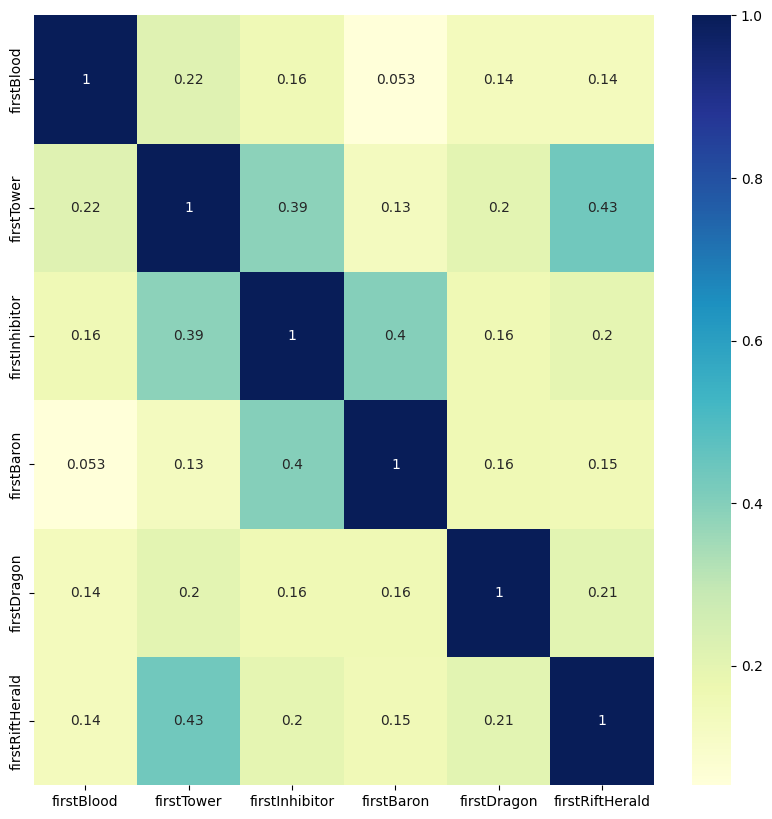

In [16]:
# Only get the needed columns
total_matches_df = total_matches_df[["win", "firstBlood", "firstTower", "firstInhibitor", "firstBaron", "firstDragon", "firstRiftHerald"]]
plt.figure(figsize = (10, 10))
sns.heatmap(total_matches_df.corr(numeric_only = True), cmap = "YlGnBu", annot = True)
plt.show()

Most of the columns seem to be unrelated except for the firstTower and firstRiftHerald which seem to be moderately related. This can be explained by the fact that a team that slays and obtains the Rift Herald can do massive damage to a tower and can more easily destroy the first tower.

#### Isolating effect of features on Win Percentage

Now, we want to see how each feature individually affects the chance that a team wins. A feature's importance can be defined as the percentage of times it agrees with the win variable. In this case, agreeing means that when the feature is false, the team lost and when the feature is true, the team won. So, the importance of a variable can be defined as the number of times it agrees with "win" divided by the number of games.

Importance = # of agreeing observations / total number of observations

Using this formula, we can see how well a feature can predict a game's end result and thus, define a sort of hierarchy of importance in a game.



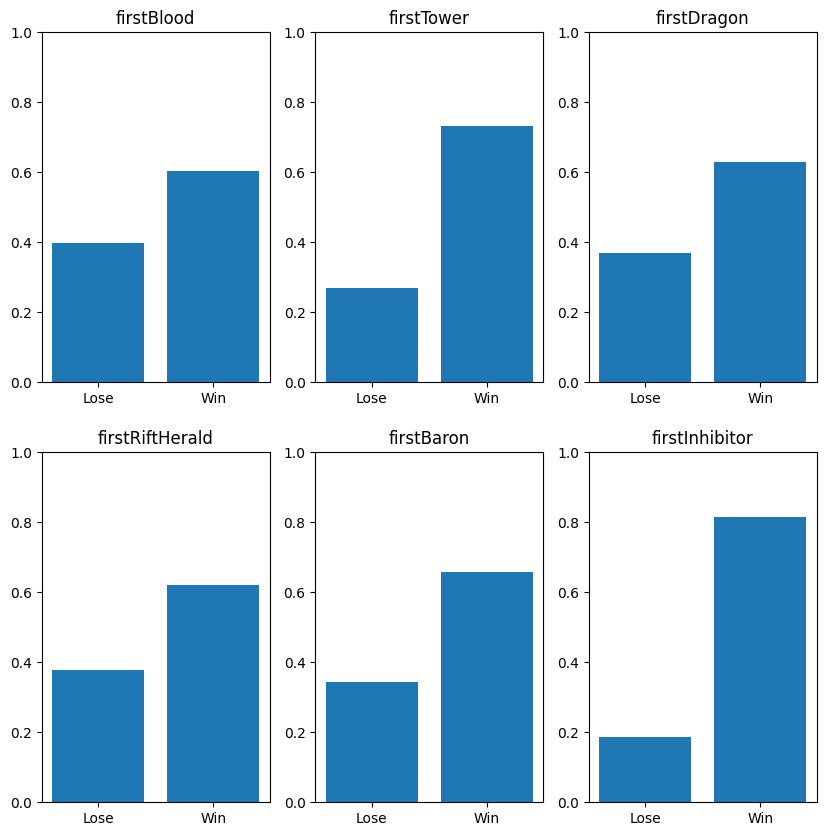

In [18]:
fig, axes = plt.subplots(2, 3, squeeze = False, figsize = (10, 10))
features = ["firstBlood", "firstTower", "firstDragon", "firstRiftHerald", "firstBaron", "firstInhibitor"]

for i in range(len(features)):
    d = total_matches_df.apply(lambda x : (x["win"] == "Win" and x[features[i]] == True or x["win"] != "Win" and x[features[i]] == False), axis = 1)
    v = d.sum() / len(d)
    h = [1 - v, v]
    # b is the row, a is the column
    a = i % 3
    b = i // 3
    axes[b][a].bar(x = ["Lose", "Win"], height = h)
    axes[b][a].set_title(features[i])
    axes[b][a].set_ylim(0, 1)
    
plt.show()

From the graphs above, we see that most features, when true, do provide a benefit to the team and increase their chances of winning. However, two features stand out amongst the group, firstInhibitor and firstTower. Why?

This can be seen from the effects of destroying an inhibitor or tower. Destroying an enemy inhibitor leads to your minions in that lane getting buffs and becoming temporarily stronger. This leads to more pressure on the enemy team which can allow you to turn that into a bigger advantage. The same cannot be said for the first tower. However, usually getting the first tower allows you to leave your assigned lane and go harass people in other lanes allowing your teammates to get an advantage. 

The advantages gained from them more easily convert into winning games than the other 4 conditions.

### Modeling and Predicting Player Data

Now that we know how important some of these features can be, we might want to try and predict a game's outcome based on these variables. The first thought that comes to mind is the __[Decision Tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)__ model from scikit-learn. The reason we use this model first is it follows from the information we just got. We were checking how important a feature is for each game. The decision tree works similar to that and can assign importances to specific features allowing us to see their effects.

To test our model, we will use 3 metrics, precision, recall, and balanced accuracy. Precision is defined as the number of positive true predictions divided by the total number of positive predictions. Recall (hit rate, true positive rate) is defined as the number of true positives divided by the number of total positives. Balanced accuracy is defined as the average of the true positive rate and the true negative rate. For more information, click __[here](https://en.wikipedia.org/wiki/Confusion_matrix)__.

In [20]:
y = total_matches_df["win"]
x = total_matches_df.drop(["win"], axis = 1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, stratify=y)


dc = DecisionTreeClassifier().fit(x_train, y_train)
pred = dc.predict(x_test)
prec = precision_score(y_true = y_test, y_pred = pred, pos_label = "Win")
rec = recall_score(y_true = y_test, y_pred = pred, pos_label = "Win")
bac = balanced_accuracy_score(y_true = y_test, y_pred = pred)

print(f"Precision: {prec}")
print(f"Recall: {rec}")
print(f"Balanced Accuracy: {bac}")
fn = ["firstBlood", "firstTower", "firstInhibitor", "firstBaron", "firstDragon", "firstRiftHerald"]
# Pad the strings with spaces to make them look better when the user is reading them
max_string_len = max([len(f"Importance of {i} :") for i in fn])
print("Feature importances:")
for (x, y) in zip(fn, dc.feature_importances_):
    s = f"Importance of {x} :"
    pos = s.find(":")
    s = s + " " * (max_string_len - len(s)) + f" {round(y, 5)}"
    print(s)


Precision: 0.8333782933189461
Recall: 0.8516034181751355
Balanced Accuracy: 0.8406585018582831
Feature importances:
Importance of firstBlood :      0.00785
Importance of firstTower :      0.13251
Importance of firstInhibitor :  0.78123
Importance of firstBaron :      0.04021
Importance of firstDragon :     0.03593
Importance of firstRiftHerald : 0.00227


Looking at our model, we see that the precision, recall, and balanced accuracy all hover around 83-85%. This means our models are reasonably able to predict a game's outcome from these features. As well, if we look at our decision tree's importances, we see that, as expected, it highly values the firstInhibitor with an importance of 0.78. We also see that features like firstRiftHerald and firstBlood have near no significance in the model. 

#### Visualizing the Decision Tree Model

We can visualize these importances and understand how the decision tree weighs them

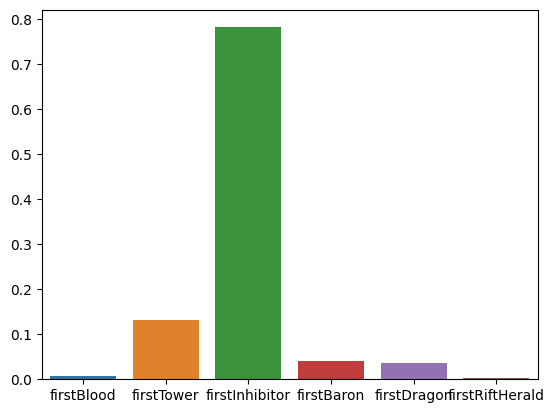

In [21]:
sns.barplot(x = fn, y = dc.feature_importances_)
plt.show()

It is also possible to graph the model and see the tree itself, but in our case, the tree splits 64 times and is very difficult to read. However, the functionality does __[exist](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html)__.

#### Looking at Confusion Matrix

Another method of evaluating a decision tree which combines precision, recall, accuracy, and all other metrics is the confusion matrix. The confusion matrix shows us what the algorithm predicted and the real value and shows us how this changes in the dataset.

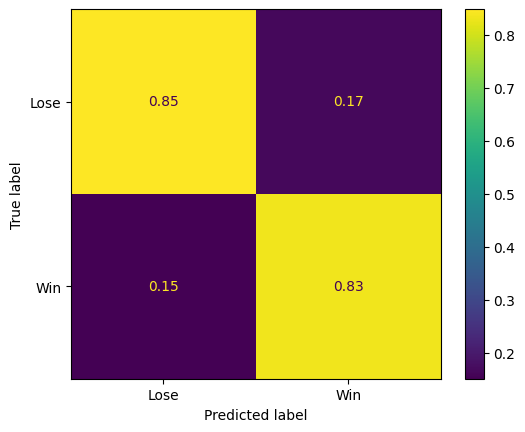

In [22]:
# Normalize the confusion matrix to display as a fraction of the predicted values
cfm = confusion_matrix(y_test, pred, normalize = "pred")

disp = ConfusionMatrixDisplay(cfm, display_labels = dc.classes_)

disp.plot()

plt.show()


As we can see from our confusion matrix, approximately 83-85% of the time, the algorithm predicts correctly since the predicted and true labels agree in those cases.

### Creating a K-Neighbors model

Let's try to look at a different learning model.

A K-Neighbors model looks at the K neighbors around that data point and checks their "win" value. In essence, we want to classify our data based on what our neighbors classify it as. If our current situation closely matches others, and they have won their game, we are likely to win ours as well. 

However, in practice, we might not know how many neighbors we should look at. Only one, nearest 5, nearest 50? We can test these values out and see where the computing cost outweighs the benefits gained by increasing the number of neighbors. Essentially, we're looking for when the slope approaches 0 and our increased precision/recall/accuracy is not worth the training/computation time.

#### Picking an optimal number of neighbors

In [23]:

y = total_matches_df["win"]
x = total_matches_df.drop(["win"], axis = 1)
indices = []
precisions = []
recalls = []
accuracies = []
# Loop over the number of neighbors we want to test with
for i in range(5, 201, 5):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, stratify=y)

    # Model with i neighbors and weight it by distance
    knn = KNeighborsClassifier(n_neighbors = i, weights = "distance").fit(x_train, y_train)
    pred = knn.predict(x_test)
    indices.append(i)
    precisions.append(precision_score(y_true = y_test, y_pred = pred, pos_label = "Win"))
    recalls.append(recall_score(y_true = y_test, y_pred = pred, pos_label = "Win"))
    accuracies.append(balanced_accuracy_score(y_true = y_test, y_pred = pred))

This takes a few minutes to train since we're training 50 models with increasing complexity and tracking their values. However, we can then graph these values and look at which number of neighbors we should try to look at.

#### Visualizing K-Neighbors Model

In [29]:
print(np.median(recalls))
print(np.median(accuracies))
print(np.median(precisions))

0.8379276547520598
0.8405750635676804
0.8424531966263769


Looking at the median values, we see that the k-neighbors model has metrics comparable to the decision tree with 83-85% for all 3 metrics. We can plot these to get a better idea of what k values to pick.

<AxesSubplot: >

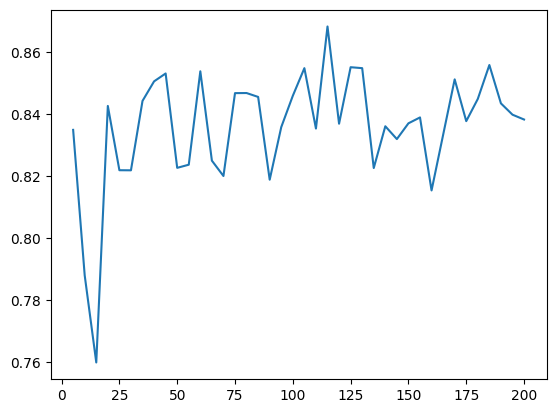

In [26]:
sns.lineplot(x = indices, y = recalls)

Looking at the graph for recalls, it seems to stabilize as we increase k, but still hovers around 84% overall. So, as long as we pick a value > 50, it's just a matter of testing with a slight change and seeing which is good.

<AxesSubplot: >

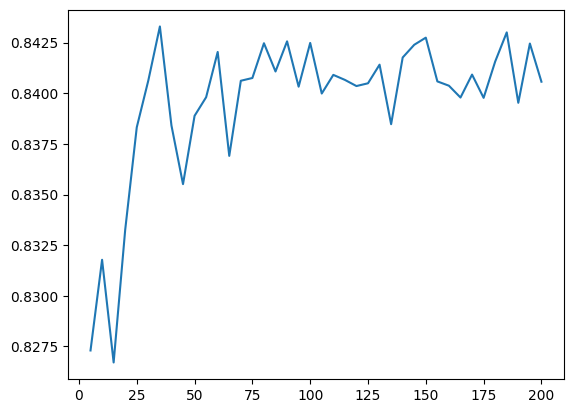

In [27]:
sns.lineplot(x = indices, y = accuracies)

Looking at accuracy, we see a similar theme with it dramatically increasing after picking k to be greater than 50 and stabilizing afterwards.

<AxesSubplot: >

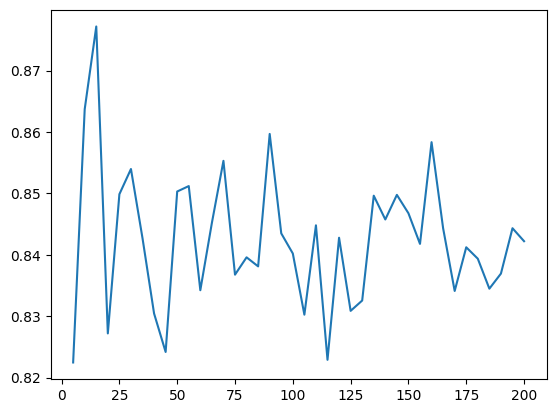

In [28]:
sns.lineplot(x = indices, y = precisions)

Finally, precision doesn't seem to have a pattern for minimum values, but we can see that the graph seems to narrow the further right we go. This could mean that doing more iterations on larger values will make us stabilize at 84-85%. 

Overall, for the values of k to choose, it seems that as long as we pick a k > 50, our results won't vary much from changing k to be slightly more or less.

## Looking at Match Data

We've looked at the specifics of the game, but now we want to look at the game in a broader sense. We know that there are 162 champions in the game, but which ones are the best? Are newer champions better?

In [45]:
matches_df.head()

,gameCreation,gameDuration,gameId,gameMode,gameType,gameVersion,mapId,participantIdentities,participants,platformId,queueId,seasonId,status.message,status.status_code
0,1.585155e+12,1323.0,4.247263e+09,CLASSIC,MATCHED_GAME,10.6.314.4405,11.0,"[{'participantId': 1, 'player': {'platformId':...","[{'participantId': 1, 'teamId': 100, 'champion...",KR,420.0,13.0,NaN,NaN
1,1.585152e+12,1317.0,4.247156e+09,CLASSIC,MATCHED_GAME,10.6.314.4405,11.0,"[{'participantId': 1, 'player': {'platformId':...","[{'participantId': 1, 'teamId': 100, 'champion...",KR,420.0,13.0,NaN,NaN
2,1.585059e+12,932.0,4.243963e+09,CLASSIC,MATCHED_GAME,10.6.313.8894,11.0,"[{'participantId': 1, 'player': {'platformId':...","[{'participantId': 1, 'teamId': 100, 'champion...",KR,420.0,13.0,NaN,NaN
3,1.584978e+12,2098.0,4.241678e+09,CLASSIC,MATCHED_GAME,10.6.313.8894,11.0,"[{'participantId': 1, 'player': {'platformId':...","[{'participantId': 1, 'teamId': 100, 'champion...",KR,420.0,13.0,NaN,NaN
4,1.584973e+12,2344.0,4.241539e+09,CLASSIC,MATCHED_GAME,10.6.313.8894,11.0,"[{'participantId': 1, 'player': {'platformId':...","[{'participantId': 1, 'teamId': 100, 'champion...",KR,420.0,13.0,NaN,NaN


In the above match dataset, we have 14 columns. We have:
1. gameCreation => unix timestamp of when the game was created
1. gameDuration => time for game to end in seconds
1. gameId => unique ID used to join this dataset and winners/losers
1. gameMode => different game modes picked for each game
1. gameType => specifies whether the game went through (matched) or was cancelled
1. gameVersion => self-explanatory
1. mapId => version of the map being used
1. participantIdentities => identities of the people playing in the match
1. participants => data about the participants (champion, win/loss, in game metrics)
1. platformId => which region the players were on (only KR in our case)
1. __[queueId](https://developer.riotgames.com/docs/lol)__ => what kind of match was played
1. __[seasonId](https://developer.riotgames.com/docs/lol)__ => which season the match was played in
1. status.message && status.status_code => NaN variables that might hold information on why a match was cancelled?

### Tidying Match Data

First, we drop all duplicates from the set of matches since it's possible there are multiple games with differing "win" variables depending on which side we're looking at. Second, we only want to look at CLASSIC matches since those are the competitive ones where we can assume players have equal skill levels and are trying their best. Other game modes may be casual and or limited time opportunities which we don't want skewing our metrics.

In [46]:
matches_df.drop_duplicates(subset = "gameId", keep = "first", inplace = True, ignore_index = True)
matches_df = matches_df[matches_df["gameMode"] == "CLASSIC"]

Here, we need to establish a set of principles for a new "win" column. It will state the side that won a match based on the stats of the first person in the participants field. The first person is always the one with a teamId of 100 (Blue side), so if they won, their whole team won and so the win goes to Blue. Similarly, if they lost, the win goes to Red.

In [47]:
matches_df["wins"] = matches_df.apply(lambda x : "Blue" if x["participants"][0]["stats"]["win"] else "Red", axis = 1)

### Getting information from match data

Since each match contains a lot of information, we can go through each one and get all the names of every champion played by each side and the roles each player picked and which lanes they picked. 

In [48]:
champs = []

for index, match in matches_df.iterrows():
    dur = match["gameDuration"]
    p = match["participants"]
    roles = []
    lanes = []
    blue_champs = []
    red_champs = []
    for i in p:
        # Add to blue or red depending on teamID
        if i["teamId"] == 100:
            blue_champs.append(i["championId"])
        else:
            red_champs.append(i["championId"])

        # Get current players selected role
        roles.append(i["timeline"]["role"])
        # Get current players lane
        lanes.append(i["timeline"]["lane"])

    # If a team is missing a player, ignore this match
    if len(blue_champs) != 5 or len(red_champs) != 5:
        continue
    
    # Add to list of matches
    for i in range(len(blue_champs)):
        champs.append([dur, blue_champs[i], "Win" if match["wins"] == "Blue" else "Lose", roles[i], lanes[i]])
    for i in range(len(red_champs)):
        champs.append([dur, red_champs[i], "Win" if match["wins"] == "Red" else "Lose", roles[i + 5], lanes[i + 5]])


### Reading champion data

Unfortunately, the champions that a person plays are stored as a key, not as the name of the champion. Riot does, however, provide a json file that gives us all the information we need about all the champions and their names and keys. However, we only require two pieces of information from this json, so we will use regex to parse it instead.

Champion names are stored as "id" : "{name}"
and keys are stored as "key" : "{key}".

Once we're done, we can map each champion's key to their name and vice-versa.


In [49]:
with open("./champion.json", "r") as f:
    data = f.read()

# Match "id" : "{w}" where w is any number of letters
p = re.compile(r"\"id\":\"(\w+)\"")
names = p.findall(data)
# Match "key" : "{d}" where d is any number of digits
q = re.compile(r"\"key\":\"(\d+)\"")
keys = q.findall(data)

champs_dict = dict(zip(keys, names)) | dict(zip(names, keys))

k = [int(i) for i in keys]
keys = sorted(k)
names = [champs_dict[str(i)] for i in keys]

As well, we notice that newer champions have a higher key value than older ones.

In [50]:
champs_df = pd.DataFrame(champs, columns = ["Match Duration", "Champion ID", "Win/Loss", "Role", "Lane"])
champs_df.head()

,Match Duration,Champion ID,Win/Loss,Role,Lane
0,1323.0,7,Lose,DUO_CARRY,MIDDLE
1,1323.0,350,Lose,DUO_SUPPORT,MIDDLE
2,1323.0,266,Lose,SOLO,TOP
3,1323.0,517,Lose,NONE,JUNGLE
4,1323.0,110,Lose,SOLO,BOTTOM


### Visualizing champion data

Let's look at the win rates for each champion based on the game. For this, we isolate every game where the Champion ID matches our specific champions key. Then we just convert the Win/Loss column to 1's and 0's and divide the sum by the length. This gives us the champion's win rate over the total number of games it has been played in. Since each team has a unique set of 5 champions that can't be picked by the other team, we can be sure that these values are accurate.

In [67]:
champs_wr = []
for name, key in zip(names, keys):
    champ_key = int(key)
    current_champ_df = champs_df[champs_df["Champion ID"] == key]
    # Convert our True/False column into a 1/0 column
    current_champ_df["Win/Loss"] = (current_champ_df["Win/Loss"] == "Win").astype(int)
    l = len(current_champ_df)
    # Only add the win rate if the number of games is > 0 
    if l != 0:
        champ_wr = current_champ_df["Win/Loss"].sum() / l
        champs_wr.append((key, champ_wr))


/tmp/ipykernel_2713/2971242163.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_champ_df["Win/Loss"] = (current_champ_df["Win/Loss"] == "Win").astype(int)


We can plot these win rates to maybe notice some trends in the champions' win rates. Graphing this with the kdeplot in seaborn gives a pretty satisfying plot that explains everything pretty well.

<AxesSubplot: >

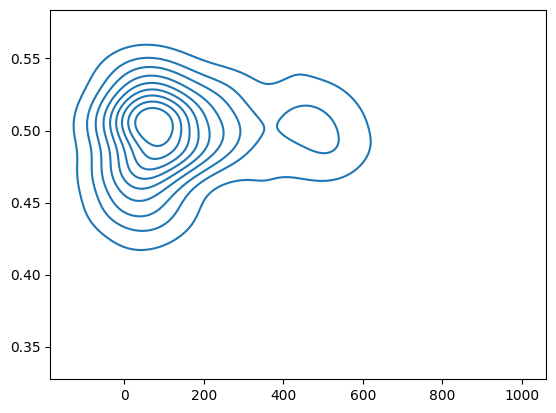

In [68]:
sns.kdeplot(data = None, x = [i[0] for i in champs_wr], y = [i[1] for i in champs_wr])

We see that there are some rings around the 50% mark and they seem concentrated around 45-55% as well. There's no discernable pattern in the data and no link between the x and y variables


However, we can't just look at the graph and state this definitively. We can use a scatter plot and regression line to show this empirically.

<AxesSubplot: >

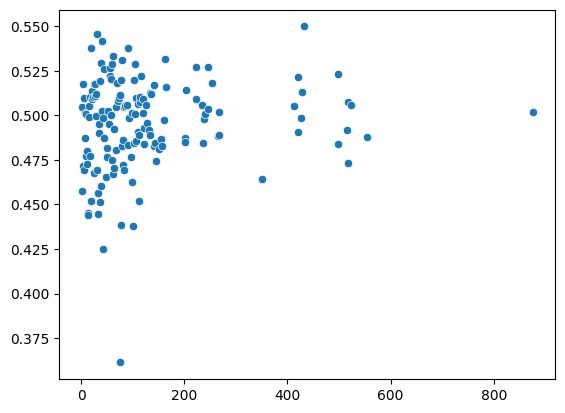

In [69]:
sns.scatterplot(data = None, x = [i[0] for i in champs_wr], y = [i[1] for i in champs_wr])

It seems that most champions hover at around 47-53% win rate with some outliers out there. Since more champions are always being introduced and old champions are being changed, the state of these win rates is only accurate for less than a season. These numbers could change the very next day and a 55% win rate champion could become terrible depending on the changes.

Let us, however, test the theory that newer champions have higher win rates than older champions. We can try to create a linear regression and see if the champions Id and win rate are related in any sense.

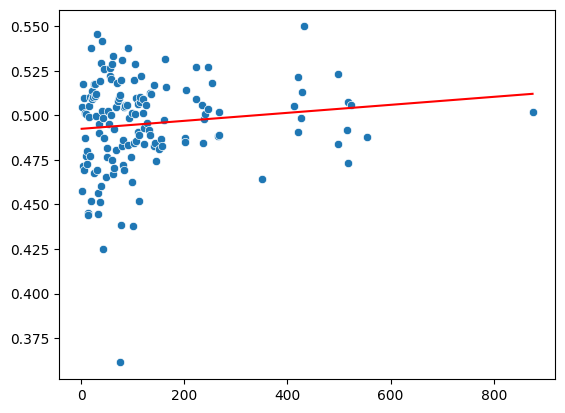

In [70]:
x_val = [i[0] for i in champs_wr]
y_val = [i[1] for i in champs_wr]

reg_model = LinearRegression().fit(X = np.reshape(x_val, (-1, 1)), y = y_val)
y_pred = reg_model.predict(np.reshape(x_val, (-1, 1)))
rsquare = reg_model.score(X = np.reshape(x_val, (-1, 1)), y = y_val)

fig, ax = plt.subplots()
# Plot scatter of win rates
p1 = sns.scatterplot(x = x_val, y = y_val, ax = ax)
# Plot regression line on top
p2 = sns.lineplot(x = x_val, y = y_pred, ax = ax, color = "r")
plt.show()

After plotting that regression line on top of our existing graph, we see that it has a near 0 slope. This indicates that the win rates of champions hover around 49-51%. We can also evaluate this line to see how well it can predict by checking it's residuals.

<AxesSubplot: >

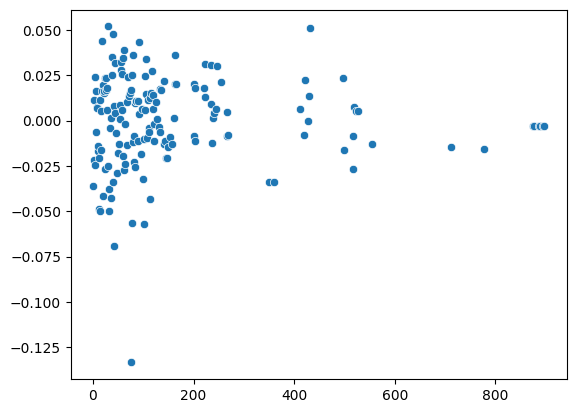

In [60]:
residuals = y_val - y_pred

sns.scatterplot(x = x_val, y = residuals)

Note that the residuals look very similar to the original graph and show that a horizontal line is still somehow the best we can get. Even then, we can get the R-square value of the regression.

In [61]:
print(f"R-Squared: {rsquare}")

R-Squared: 0.010429158729092003


That low value of R-Squared tells us that there is no relation between champion win rates and their keys.

## Conclusion


The game might seem very complex to a newcomer, but hopefully this tutorial explained the relations between some basic in-game concepts and how they affect a match's outcome. For the experienced players, I hope that this has provided you with some more insight on information that might seem like second-nature to you, but that might confuse others. Even if you're not interested in MOBAs, they offer a very good platform for data analysis due to the vast amount of information they store in each game and play. This massive amount of information allows us to see a lot of relations that wouldn't be possible without years of playing.

However, even though we have gained some insights from this data, there's a lot more information left in these datasets. They contain item choices, rune trees, in-game timed statistics, and more. These statistics could also be combined to reveal more information on the effects of these individual features on the game's eventual outcome. As well, we only looked at the top echelon of the ranked leaderboard. We could look to see lower ranked games and see how their decisions differ from those in the higher ranks. Perhaps, they value objectives differently and have skewed champion win rates.